# Training on 13,231 events from ACTS. Testing on 3308 events from ACTS.

In [1]:
!nvidia-smi

Mon Aug 28 15:23:15 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   27C    P8     9W / 180W |    434MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   29C    P8     9W / 180W |      2MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from keras.regularizers import l2
from tracker import extractor as ext, utils, metrics, visuals

### Load in the data.

In [ ]:
%%time
# This is how the ACTS data was cleaned.
# Don't run this cell unless you want to overwrite the current cleaned data.
mapper = {}
for key in range(  30,   35): mapper[key] = 32
for key in range(  70,   75): mapper[key] = 72
for key in range( 115,  120): mapper[key] = 117
for key in range( 170,  175): mapper[key] = 172
for key in range( 255,  270): mapper[key] = 260
for key in range( 355,  370): mapper[key] = 360
for key in range( 495,  510): mapper[key] = 500
for key in range( 655,  670): mapper[key] = 660
for key in range( 815,  830): mapper[key] = 820
for key in range(1010, 1030): mapper[key] = 1020

print("Loading in the frame.")
filepath   = "data/sets/progenitors/ACTS.gz"
events     = utils.list_of_groups(pd.read_csv(filepath), "event_id")
frame      = pd.concat([event for event in events if metrics.number_of_tracks(event) <= 25])
frame["r"] = frame["r"].round().map(mapper)
frame.drop_duplicates(["event_id", "cluster_id", "r"], keep="first", inplace=True)
print("Preparing the frame.")
frame = ext.prepare_frame(frame, n_tracks=25, n_rows=260, n_noise=10)
frame = frame.sample(frac=1)
print(frame["cluster_id"].max())
print("Saving the frame.")
frame.to_csv("data/sets/ACTS-10N-25T.gz", compression="gzip")

In [3]:
%%time
modelpath = "data/models/ACTS-10N-25T-260R-REGULARIZERS.h5"
filepath  = "data/sets/ACTS-10N-25T.gz"
frame     = pd.read_csv(filepath)
events    = [event for (_, event) in frame.groupby("event_id", sort=False)]
percent   = 0.8
cutoff    = int(percent * len(events))
train, test = events[:cutoff], events[cutoff:]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
if (not utils.is_prepared(train[0])) or (not utils.is_prepared(test[0])):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py") 

Train is list of 13232 events.
Test is list of 3308 events.
CPU times: user 6.62 s, sys: 180 ms, total: 6.8 s
Wall time: 6.8 s


In [4]:
order = ["phi", "r", "z"]

### Get an idea for how the tracks are distributed among the events.

In [ ]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

In [ ]:
dist = metrics.distributions(pd.concat(test))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

### Show an example of the data.

Train 424
Number of Hits: 105
Number of Tracks: 16


<IPython.core.display.Javascript object>


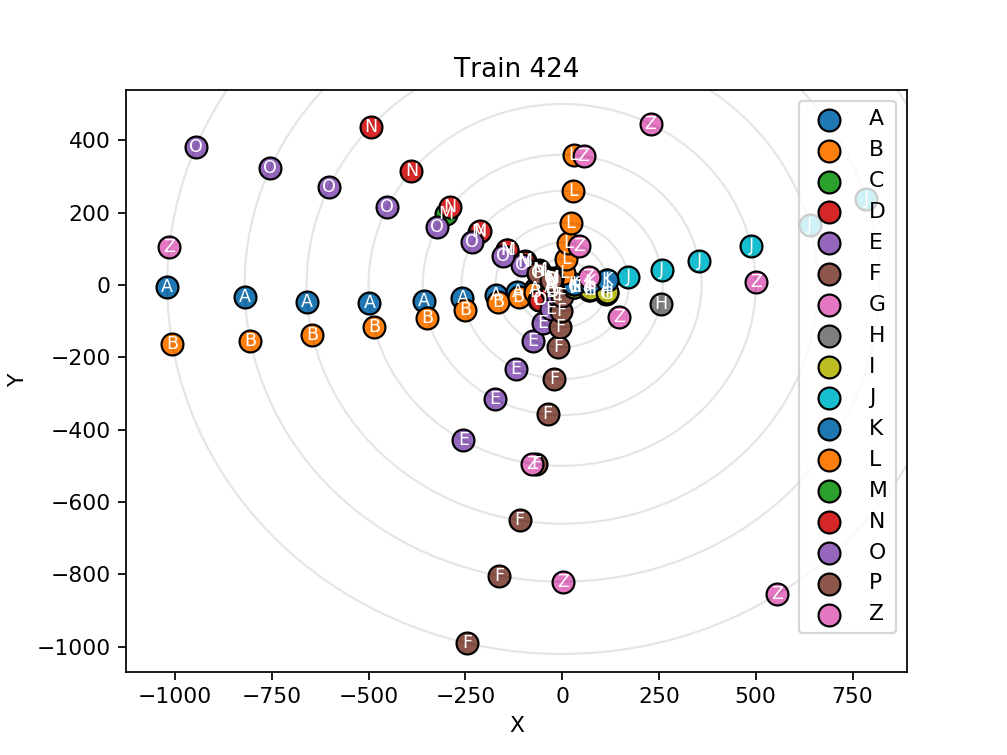

In [5]:
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

### Create the model.

In [22]:
input_shape  = (260, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2, kernel_regularizer=l2()),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2, kernel_regularizer=l2()),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2, kernel_regularizer=l2()),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 260, 256)          399360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 260, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 260, 256)          787968    
_________________________________________________________________
dropout_2 (Dropout)          (None, 260, 256)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 260, 256)          787968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 260, 256)          0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 260, 27)           6939      
Total para

### Fit the model.

In [23]:
%%time
#12
epochs     = 8
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
    keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)]))

Epoch 1/8
132/132 [==============================] - 214s - loss: 2.4160 - acc: 0.6585 - val_loss: 0.9534 - val_acc: 0.7022
Epoch 2/8
132/132 [==============================] - 207s - loss: 0.9466 - acc: 0.6951 - val_loss: 0.8469 - val_acc: 0.7174
Epoch 3/8
132/132 [==============================] - 208s - loss: 0.8592 - acc: 0.7096 - val_loss: 0.9702 - val_acc: 0.6889
Epoch 4/8
132/132 [==============================] - 209s - loss: 0.7981 - acc: 0.7215 - val_loss: 0.9410 - val_acc: 0.6872
Epoch 5/8
132/132 [==============================] - 208s - loss: 0.7609 - acc: 0.7300 - val_loss: 0.6749 - val_acc: 0.7554
Epoch 6/8
132/132 [==============================] - 207s - loss: 0.7263 - acc: 0.7395 - val_loss: 0.6064 - val_acc: 0.7757
Epoch 7/8
132/132 [==============================] - 207s - loss: 0.7033 - acc: 0.7451 - val_loss: 0.6498 - val_acc: 0.7569
Epoch 8/8
132/132 [==============================] - 209s - loss: 0.6754 - acc: 0.7526 - val_loss: 0.5876 - val_acc: 0.7804
CPU time

### Display information about the model after fitting it.

In [12]:
%%time
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 0.0%
Percent of tracks assigned correctly: 0.0%
Percent of events with the correct number of tracks: 0.0%
CPU times: user 1min 8s, sys: 168 ms, total: 1min 8s
Wall time: 1min 10s


### Display how one of the model's predictions looks.

Percent of hits assigned correctly: 0.0%
Percent of tracks assigned correctly: 0.0%


<IPython.core.display.Javascript object>


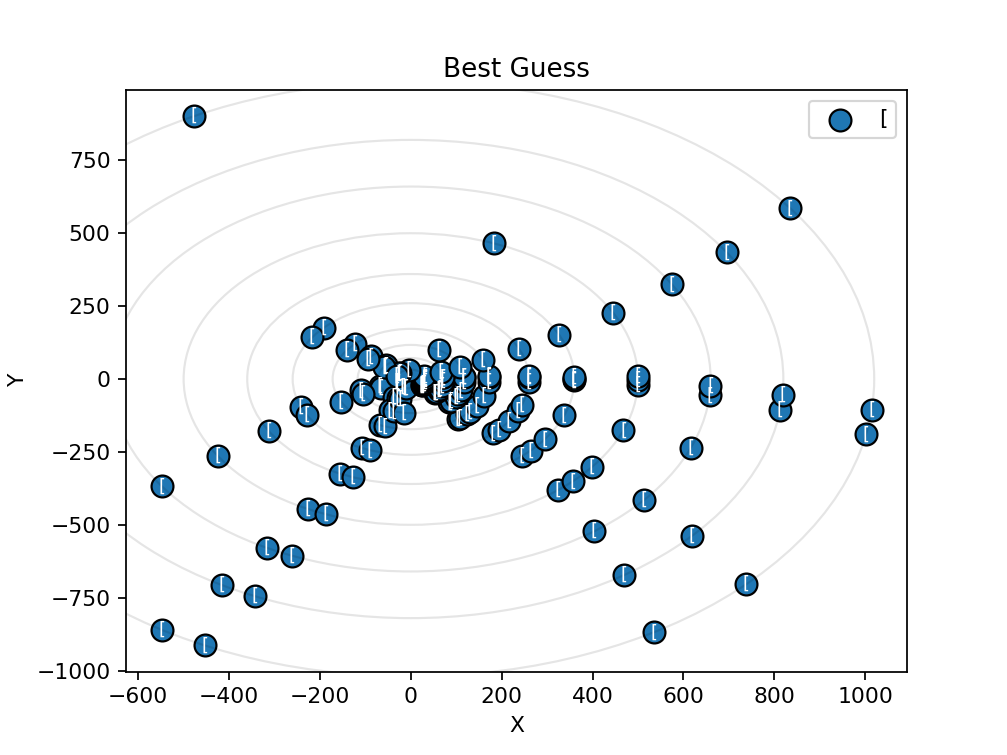

<IPython.core.display.Javascript object>


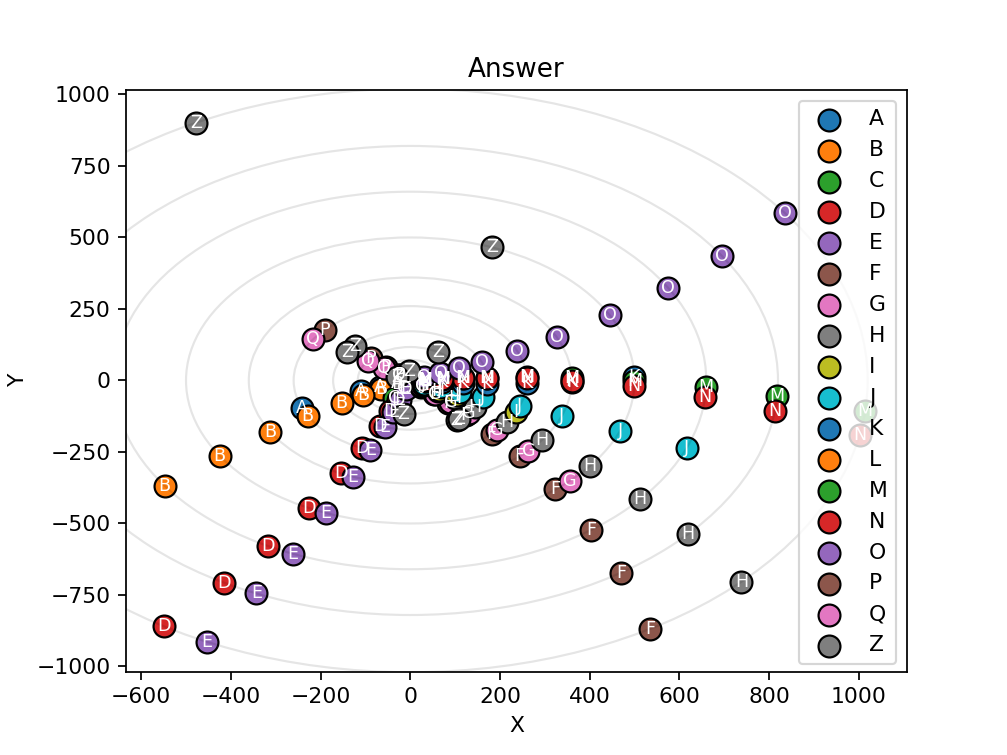

In [13]:
n  = 6
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
d = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy", title="Best Guess")
d = visuals.Plot2D(test[n], order).plot(mode="xy", title="Answer")

In [15]:
visuals.display(test[n], order, guesses[n], mode="pairs")

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-2.828076,32.0,-117.488000,`1`[0.05000000074505806],`0`[0.05000000074505806],`0`[0.05000000074505806],`0`[0.05000000074505806],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.07999999821186066],`0`[0.1899999976158142]
1,-2.817629,72.0,-236.197000,`1`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.07000000029802322],`0`[0.25999999046325684]
2,-2.806223,117.0,-366.072000,`1`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.07000000029802322],`0`[0.25]
3,-2.767547,260.0,-800.000000,`1`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.07000000029802322],`0`[0.25]
4,-2.700047,32.0,-72.628100,`0`[0.03999999910593033],`1`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.019999999552965164],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.009999999776482582],`0`[0.07000000029802322],`0`[0.25]
5,-2.690382,72.0,-134.784000,`0`[0.03999999910593033],`1`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.03999999910593033],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329447746],`0`[0.029999999329